In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import niskine
import mplniw.sigp as sp
import mplniw.plot as pl
import mplniw.utils as ut

In [2]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/data/'

In [3]:
mooring=1
wind_work = xr.open_dataset(root_dir+'wind_work/ni_wind_work_niskine_m1.nc')
#gridded = xr.open_dataset(root_dir+'data/gridded/M%s_gridded_simple_merge_gaps_filled.nc'%mooring)
#filtered = xr.open_dataset('/Users/zcasparcohen/Documents/NISKINE/data/filtered_convolve.nc')

gridded = xr.open_dataset(root_dir+'M%s_linear_merge_slinearfill.nc'%mooring)
#filtered = xr.open_dataset(root_dir+'gridded/M%s_bpfiltered.nc'%mooring)

In [4]:
if False:
    ds_filtered = sp.ni_bandpass_adcp(gridded)
    ds_filt,wkb = sp.calc_ni_eke(ds_filtered)
    ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
    ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
    ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
    ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb
    ds_filt['wkb'] = wkb
    ds_filt.ni_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
    ds_filt.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
    ds_filt.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})
    ds_filt.to_netcdf(root_dir+'data/M%s_bpfiltered.nc'%mooring)
if True:
    ds_filt = xr.open_dataset(root_dir+'M%s_bpfiltered.nc'%mooring)

In [5]:
ds_filt


<xarray.Dataset>
Dimensions:     (z: 125, time: 73057)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z           (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
Data variables:
    u           (z, time) float64 ...
    v           (z, time) float64 ...
    u_filtered  (z, time) float64 ...
    v_filtered  (z, time) float64 ...
    bp_eke      (z, time) float64 ...
    ke          (z, time) float64 ...
    eke         (z, time) float64 ...
    bpu_wkb     (z, time) float64 ...
    bpv_wkb     (z, time) float64 ...
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

In [6]:
import pandas as pd
mld_m1 = xr.open_dataarray(conf.data.ml.mld).sel(time=slice(ds_filt.time[0],ds_filt.time[-1]))
ds_filt['mld'] = mld_m1
ds_filt['bp_eke'] = ds_filt.bp_eke.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds_filt['bpu_wkb'] = ds_filt.bpu_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds_filt['bpv_wkb'] = ds_filt.bpv_wkb.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds_filt['u_filtered'] = ds_filt.u_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)
ds_filt['v_filtered'] = ds_filt.v_filtered.sel(z=slice(10,1600)).interpolate_na('time',max_gap=pd.Timedelta(12, "h"),method='polynomial',order=7)

In [7]:
ds_filt['ni_UV'] = (ds_filt['bpu_wkb'] + 1j * ds_filt['bpv_wkb']).fillna(0.)
ds_filt['UV'] = (ds_filt['u'] + 1j * ds_filt['v']).fillna(0.)
fc = ut.coriolis(lat)*3600*24/2/np.pi

### Global

In [8]:
Nb = 30*24*6
f,E = sp.wrap_spectra(ds_filt,'UV',Nb=Nb,**{'return_onesided':True})

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:1870: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '


/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


(<matplotlib.patches.Rectangle at 0x16ca88e10>,
 (<matplotlib.patches.ConnectionPatch at 0x16cb2a110>,
  <matplotlib.patches.ConnectionPatch at 0x16cb73ad0>))

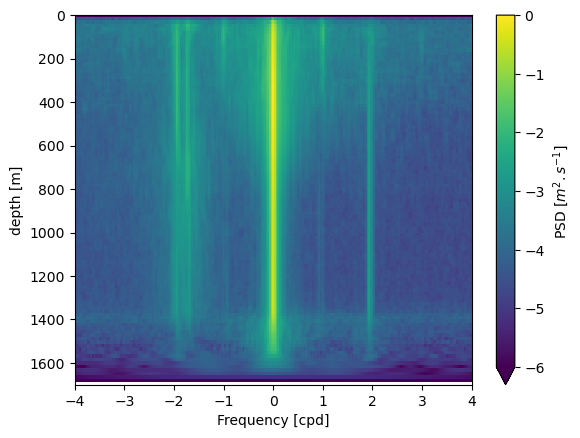

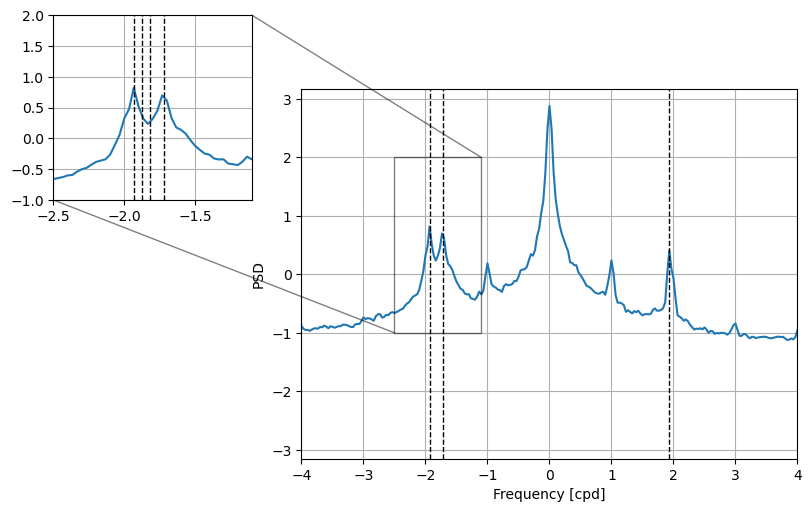

In [18]:
# Power spectra depending on depth
fig,ax = plt.subplots()
np.log10(E).plot(ax=ax,yincrease=False,xlim=(-4,4),ylim=(1700,0),vmax=0,vmin=-6)

# Integrated rotary spectra
fig,ax = plt.subplots()
np.log10(E.integrate(coord='z')).plot(ax=ax,xlim=(-4,4));
ax.set_ylabel('PSD');
for v in [-1.93,1.93,-fc]:
    ax.axvline(v,c='k',lw=1,ls='--')
ax.grid();
#fig,ax = plt.subplots()
#np.log10(_E).plot(ax=ax,yincrease=False,xlim=(-4,4),vmax=0,vmin=-6)

axins = ax.inset_axes([-0.5, 0.7, 0.4, 0.5])
np.log10(E.integrate('z')).plot(ax=axins)
axins.set_xlim((-2.5),(-1.1))
axins.set_ylim((-1),(2))
axins.set_ylabel('');axins.set_xlabel('');axins.grid();
axins.axvline(-1.93,c='k',ls='--',lw=1);axins.axvline(-fc,c='k',ls='--',lw=1);
axins.axvline(-fc-0.1,c='k',ls='--',lw=1);axins.axvline(-1.8747,c='k',ls='--',lw=1);
ax.indicate_inset_zoom(axins,edgecolor='black')

In [12]:
fc

1.720854399161123

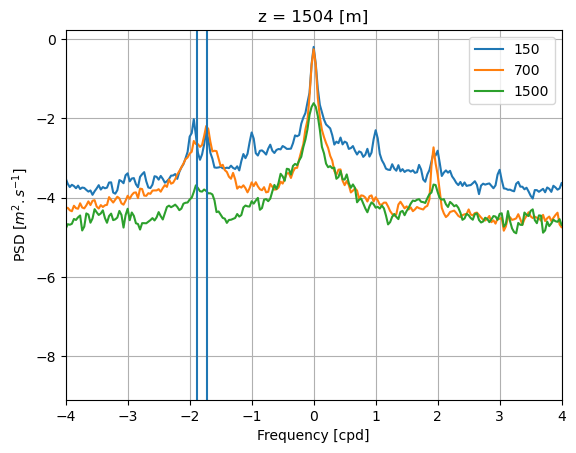

In [15]:
fig,ax = plt.subplots()
np.log10(E.sel(z=150,method='nearest')).plot(ax=ax,xlim=(-4,4),label=150)
#np.log10(E.sel(z=500,method='nearest')).plot(ax=ax,xlim=(-4,4))
np.log10(E.sel(z=700,method='nearest')).plot(ax=ax,xlim=(-4,4),label=700)
np.log10(E.sel(z=1500,method='nearest')).plot(ax=ax,xlim=(-4,4),label=1500)
ax.legend()
ax.grid();ax.axvline(-fc);ax.axvline(-1.8747)

### Seasonal: JFM - JJA

In [11]:
Nb = 30*24*6
f,E_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'UV',Nb=Nb)
f,E_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'UV',Nb=Nb)

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


Text(0.5, 1.0, 'Summer: JJA')

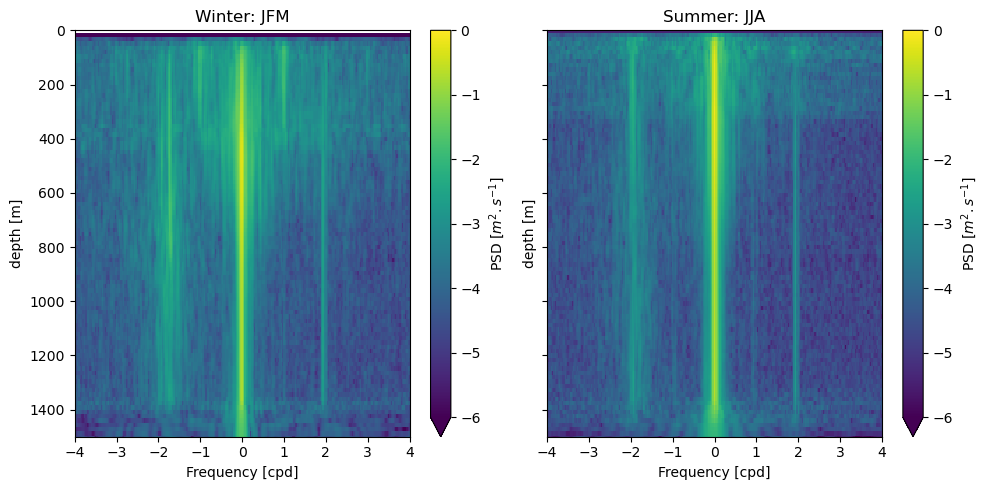

In [12]:

fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True,tight_layout=True)
np.log10(E_winter).plot(ax=ax[0],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
ax[0].set_title('Winter: JFM')
np.log10(E_summer).plot(ax=ax[1],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
ax[1].set_title('Summer: JJA')

#### Comments:

Winter: Near-inertial signal is dominant (compared to semidiurnal tide) and easily disctint from tidal signal from surface to $\sim$ 900m depth. From there downward the amplitudes of both motions are similar but the gap between frequencies is large enough that bandpass filtering extracts most of the NI signal (if the bandwidth is narrow enough).

Summer : Semi-diurnal tide is dominant at all depth. And vorticity mostly positive (cf draft paper), resulting in a frequency shift.
Both effects combined make almost impossible (using bandpass filtering) to separate near-inertial oscillations from tidal signal.



Conclusion, any event of high NI KE observed during summer is most likely highly contaminated by tidal signal. This is not a big problem as we actually don't observe any significantly high KE levels during this period of the year. It might become one however at other locations with similar latitudes.
In winter, NI signal at depth may be contaminated by semidiurnal tide, especially if tides or NIW (or both) are strongly non-stationary.

(<matplotlib.patches.Rectangle at 0x14c7e1f10>,
 (<matplotlib.patches.ConnectionPatch at 0x14ac034d0>,
  <matplotlib.patches.ConnectionPatch at 0x14cd14b10>))

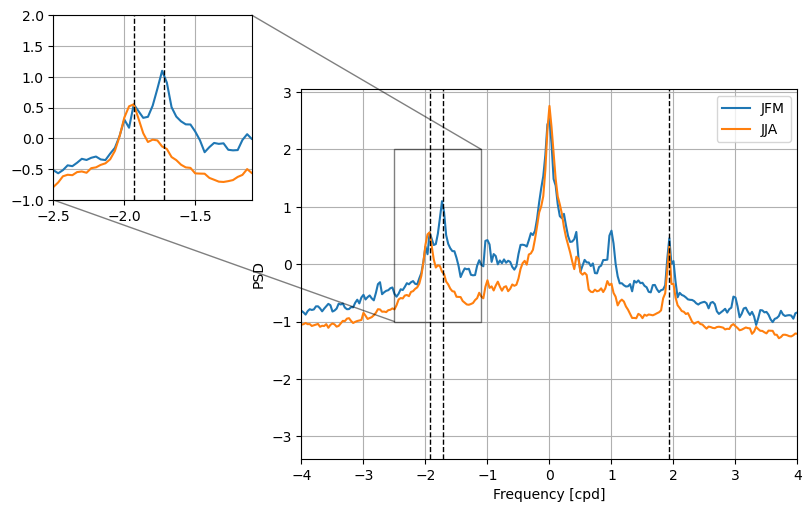

In [23]:
fig,ax = plt.subplots()
np.log10(E_winter.integrate('z')).plot(ax=ax,xlim=(-4,4),label='JFM')
np.log10(E_summer.integrate('z')).plot(ax=ax,xlim=(-4,4),label='JJA')
ax.legend();ax.set_ylabel('PSD')
for v in [-1.93,1.93,-fc]:
    ax.axvline(v,lw=1,ls='--',c='k')
ax.grid();
axins = ax.inset_axes([-0.5, 0.7, 0.4, 0.5])
np.log10(E_winter.integrate('z')).plot(ax=axins)
np.log10(E_summer.integrate('z')).plot(ax=axins)
axins.set_xlim((-2.5),(-1.1))
axins.set_ylim((-1),(2))
axins.set_ylabel('');axins.set_xlabel('');axins.grid();
axins.axvline(-1.93,c='k',ls='--',lw=1);axins.axvline(-fc,c='k',ls='--',lw=1);
ax.indicate_inset_zoom(axins,edgecolor='black')

#### Comments:
Winter: Near-inertial signal is dominant and easily disctint from tide.

Summer : Semi-diurnal tide is dominant. And vorticity mostly positive (cf draft paper), resulting in a frequency shift.
Both effects combinded make almost impossible (using bandpass filtering) to separate near-inertial oscillations from tidal signal.

Conclusion, any event of high NI KE observed during summer is most likely highly contaminated by tidal signal. This is not a big proble; since we actually don't observe any significantly high KE levels during this period of the year

In [13]:
f,E_January = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-02-01')),'UV',Nb=Nb)


(<matplotlib.patches.Rectangle at 0x16c45ff90>,
 (<matplotlib.patches.ConnectionPatch at 0x14f6a1490>,
  <matplotlib.patches.ConnectionPatch at 0x16c45e790>))

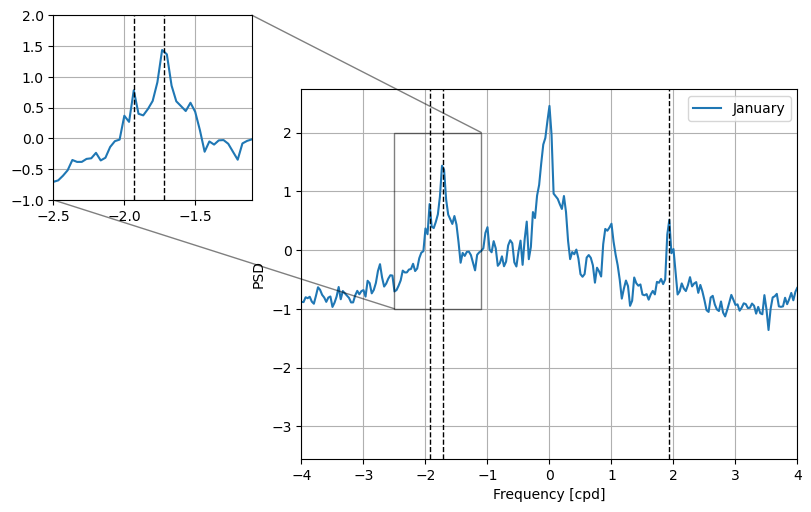

In [17]:
fig,ax = plt.subplots()
#np.log10(E_winter.integrate('z')).plot(ax=ax,xlim=(-4,4),label='JFM')
np.log10(E_January.integrate('z')).plot(ax=ax,xlim=(-4,4),label='January')
ax.legend();ax.set_ylabel('PSD')
for v in [-1.93,1.93,-fc]:
    ax.axvline(v,lw=1,ls='--',c='k')
ax.grid();
axins = ax.inset_axes([-0.5, 0.7, 0.4, 0.5])
#np.log10(E_winter.integrate('z')).plot(ax=axins)
np.log10(E_January.integrate('z')).plot(ax=axins)
axins.set_xlim((-2.5),(-1.1))
axins.set_ylim((-1),(2))
axins.set_ylabel('');axins.set_xlabel('');axins.grid();
axins.axvline(-1.93,c='k',ls='--',lw=1);axins.axvline(-fc,c='k',ls='--',lw=1);
ax.indicate_inset_zoom(axins,edgecolor='black')

### Wind events

In [24]:
# "a la main":
ti = ['2019-11-09T02:00:00.000000000','2020-01-03T01:00:00.000000000',
      '2020-02-13T02:00:00.000000000','2020-03-08T12:00:00.000000000']
tf = ['2019-11-22T09:00:00.000000000','2020-01-19T14:00:00.000000000',
      '2020-02-26T19:00:00.000000000','2020-03-25T04:00:00.000000000']
months = ['2029-11','2020-01','2020-02','2020-03']

In [25]:
spectra_month,spectra_event = {}, {}
for index in range(len(ti)):
    Nb = 30*24*6
    f,EJ = sp.wrap_spectra(ds_filt.sel(time=slice(ti[index][:8]+'01',ti[index][:5]+ti[index][5]+str(int(ti[index][6])+1)+'-01')),'UV',Nb=Nb)
    Nb = ds_filt['UV'].isel(z=1).sel(time=slice(ti[index],tf[index])).time.size
    f,EJevent = sp.wrap_spectra(ds_filt.sel(time=slice(ti[index],tf[index])),'UV',Nb=Nb)
    spectra_event[str(index)] = EJevent
    spectra_month[str(index)] = EJ

In [26]:
import matplotlib.gridspec as gridspec

/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/Users/zcasparcohen/miniconda3/envs/mpl_niw/lib/python3.11/site-packages/xarray/core/computation.py:761: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


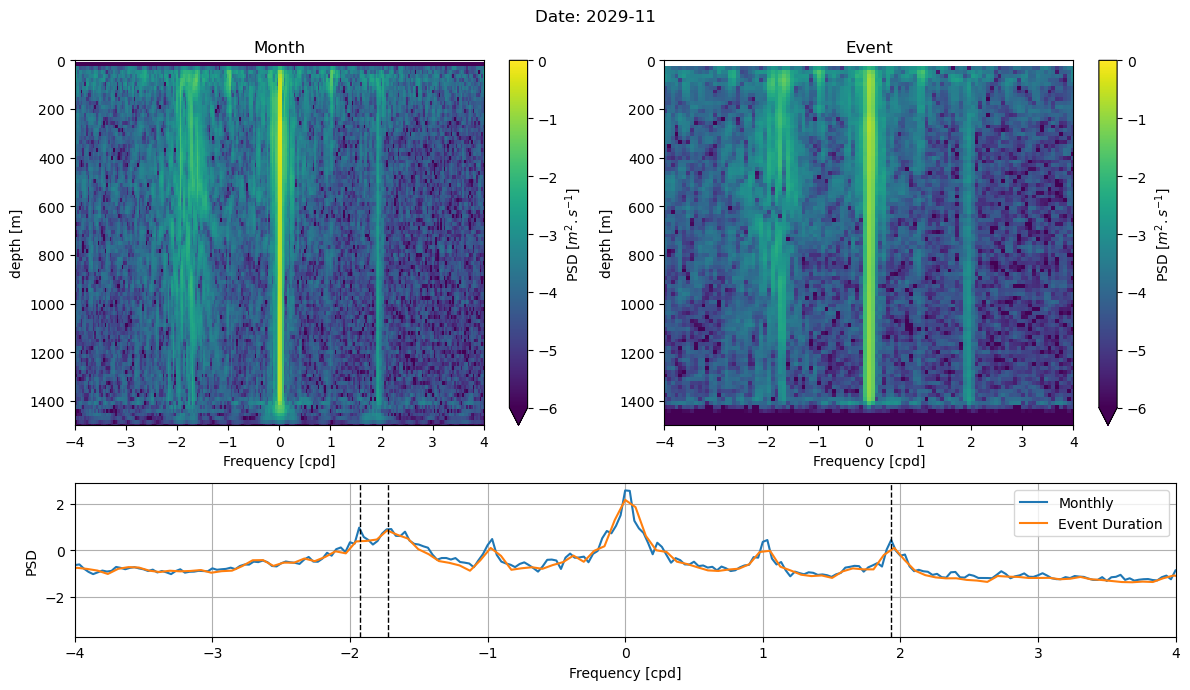

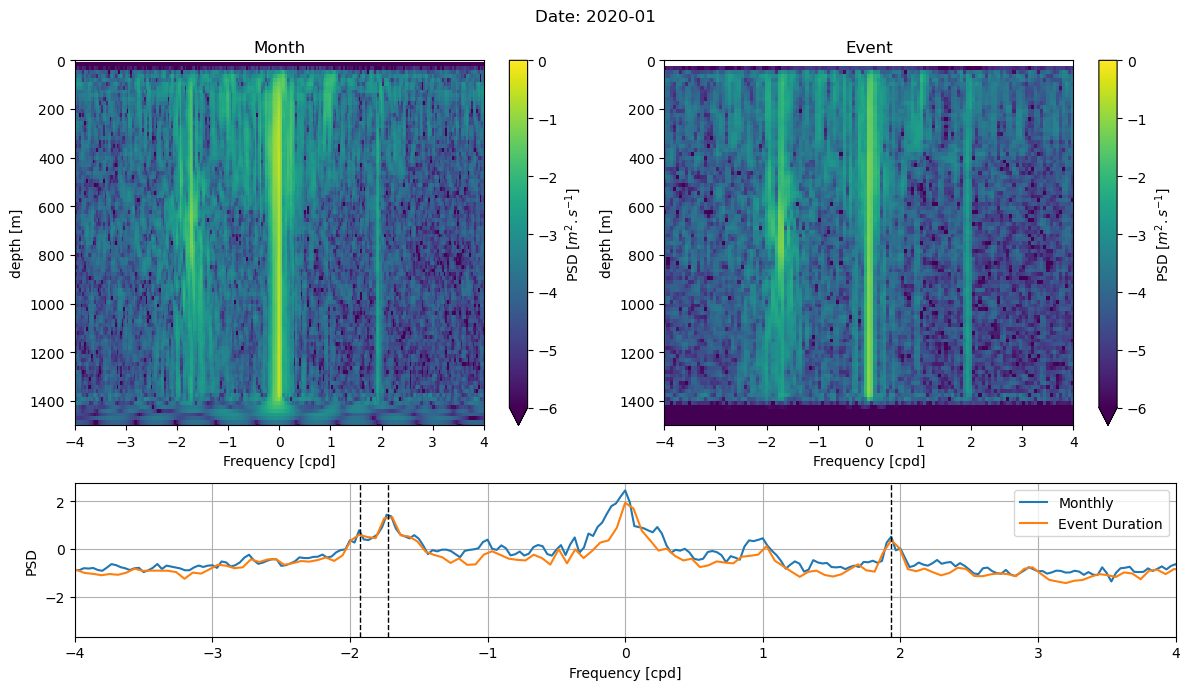

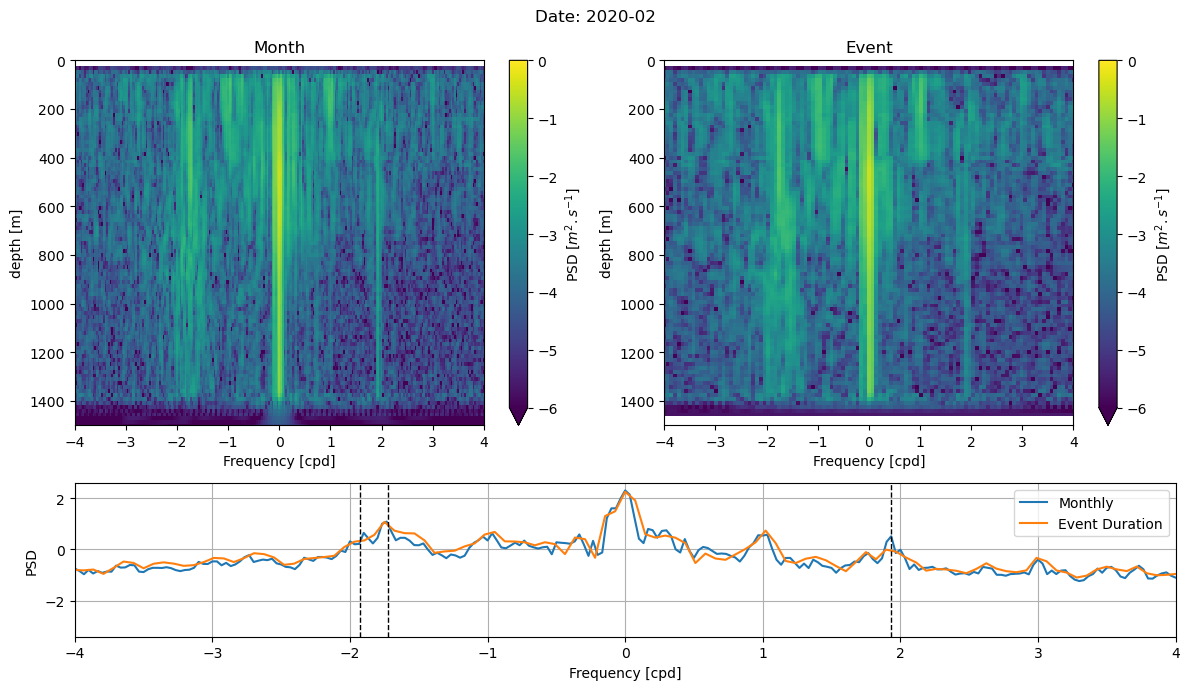

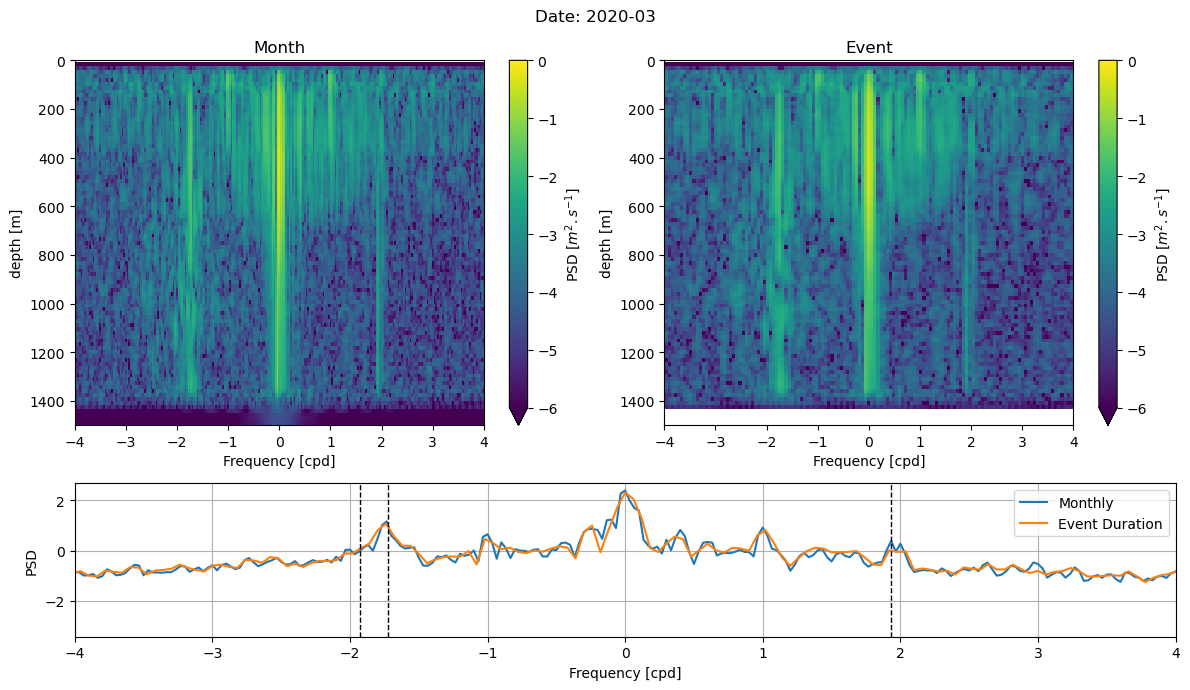

In [27]:
for index in range(len(ti)):
    _E = spectra_month[str(index)]
    _Eevent = spectra_event[str(index)]
    fig = plt.figure(tight_layout=True,figsize=(12,7))
    gs = gridspec.GridSpec(3,2)
    ax = fig.add_subplot(gs[:2,0])
    np.log10(_E).plot(ax=ax,yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
    ax.set_title('Month')
    ax = fig.add_subplot(gs[:2,1])
    np.log10(_Eevent).plot(ax=ax,yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=0,vmin=-6)
    ax.set_title('Event')
    
    ax = fig.add_subplot(gs[2,:])
    np.log10(_E.integrate('z')).plot(ax=ax,xlim=(-4,4),label='Monthly')
    np.log10(_Eevent.integrate('z')).plot(ax=ax,xlim=(-4,4),label='Event Duration')
    ax.legend();ax.set_ylabel('PSD')
    for v in [-1.93,1.93,-fc]:
        ax.axvline(v,lw=1,ls='--',c='k')
    ax.grid();
    fig.suptitle('Date: %s'%months[index])

#### 'Classic' PSD for u and v

In [28]:
ds_filt['u'] = ds_filt.u.fillna(0)
ds_filt['v'] = ds_filt.v.fillna(0)

In [29]:
Nb = 30*24*6
f,_Eu_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'u',Nb=Nb,**{'return_onesided':True})
f,_Eu_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'u',Nb=Nb,**{'return_onesided':True})

f,_Ev_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'v',Nb=Nb,**{'return_onesided':True})
f,_Ev_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'v',Nb=Nb,**{'return_onesided':True})

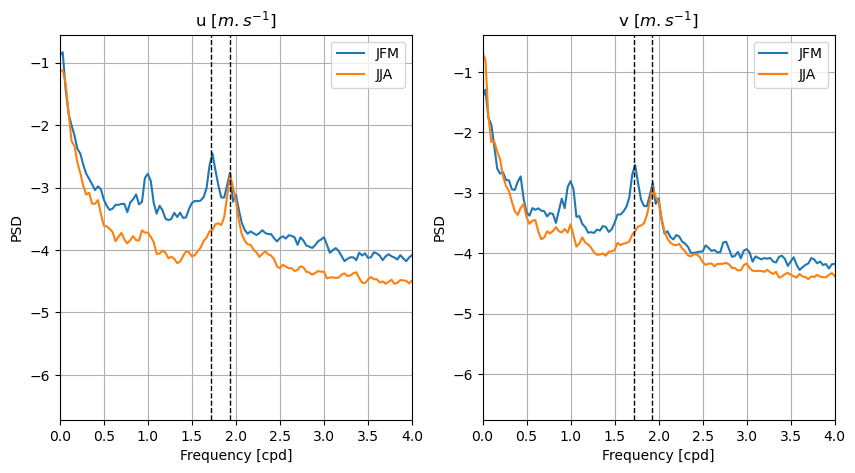

In [30]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(_Eu_winter.mean('z')).plot(ax=ax[0],xlim=(0,4),label='JFM')
np.log10(_Eu_summer.mean('z')).plot(ax=ax[0],xlim=(0,4),label='JJA')
ax[0].set_title(r'u [$m.s^{-1}$]')
np.log10(_Ev_winter.mean('z')).plot(ax=ax[1],xlim=(0,4),label='JFM')
np.log10(_Ev_summer.mean('z')).plot(ax=ax[1],xlim=(0,4),label='JJA')
ax[1].set_title(r'v [$m.s^{-1}$]')
for a in ax:
    a.legend();a.set_ylabel('PSD')
    for v in [1.93,fc]:
        a.axvline(v,lw=1,ls='--',c='k')
    a.grid();

### Shear spectra

In [34]:
wkb = niskine.clim.get_wkb_factors(ds_filt)
ds_filt['uz'] = wkb*ds_filt['u'].differentiate('z')
ds_filt['vz'] = wkb*ds_filt['v'].differentiate('z')
ds_filt['UVz'] = ds_filt['uz']+1j*ds_filt['vz']

In [35]:
Nb = 30*24*6
f,E = sp.wrap_spectra(ds_filt,'UVz',Nb=Nb)

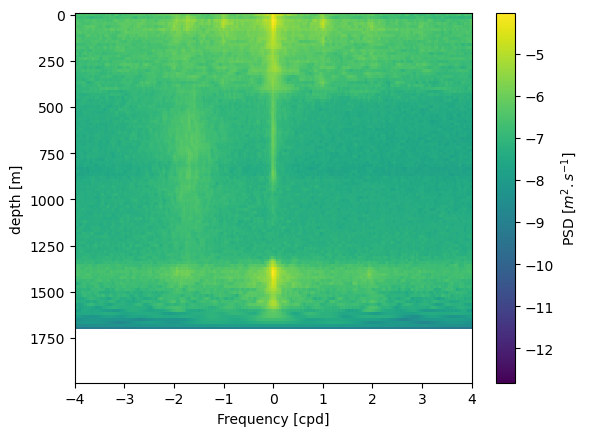

In [39]:
np.log10(E).plot(yincrease=False,xlim=(-4,4))

In [40]:
Nb = 30*24*6
f,E_winter = sp.wrap_spectra(ds_filt.sel(time=slice('2020-01-01','2020-04-01')),'UVz',Nb=Nb)
f,E_summer = sp.wrap_spectra(ds_filt.sel(time=slice('2020-06-01','2020-09-01')),'UVz',Nb=Nb)

Text(0.5, 1.0, 'Summer: JJA')

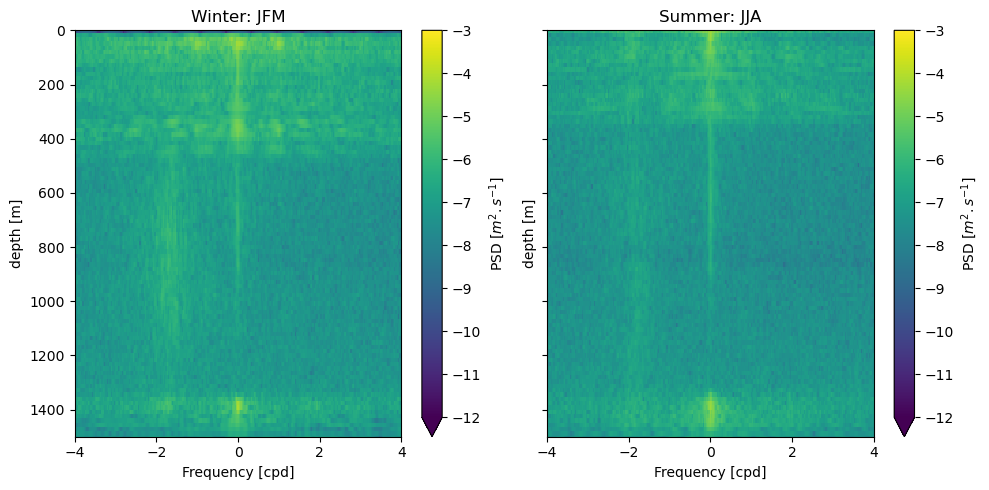

In [45]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharey=True,tight_layout=True)
np.log10(E_winter).plot(ax=ax[0],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=-3,vmin=-12)
ax[0].set_title('Winter: JFM')
np.log10(E_summer).plot(ax=ax[1],yincrease=False,xlim=(-4,4),ylim=(1500,0),vmax=-3,vmin=-12)
ax[1].set_title('Summer: JJA')

In [52]:
import scipy.signal as signal
import scipy.fftpack as fftpack

In [60]:

_ = fftpack.fft2(ds_filt.UV.values)

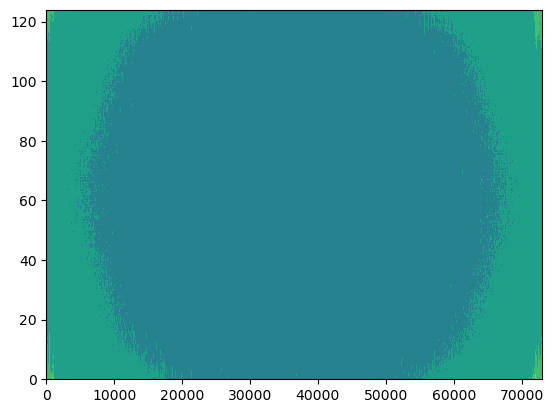

In [62]:
plt.contourf(np.log(_))